# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from preprocessing import *
from data_quantity_analysis import *
from cliches import *

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Preprocessing

In [3]:
(
    articles,
    categories,
    links,
    paths_finished,
    paths_unfinished,
) = import_and_clean_data()

# Data quantity analysis - exploratory data analysis

<Figure size 1000x900 with 0 Axes>

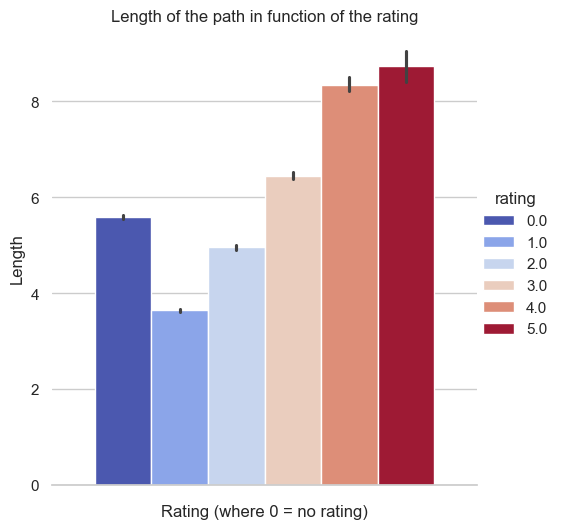

In [4]:
rating_vs_path_length(paths_finished, show=True)

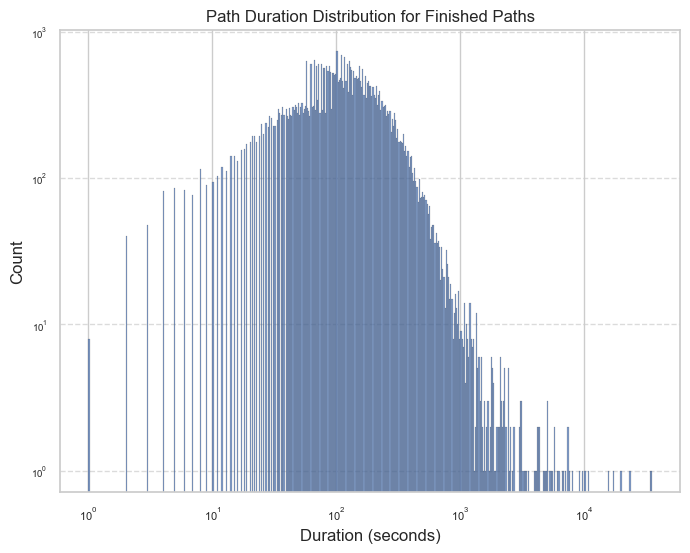

In [25]:
path_duration_distribution(paths_finished, show=True)

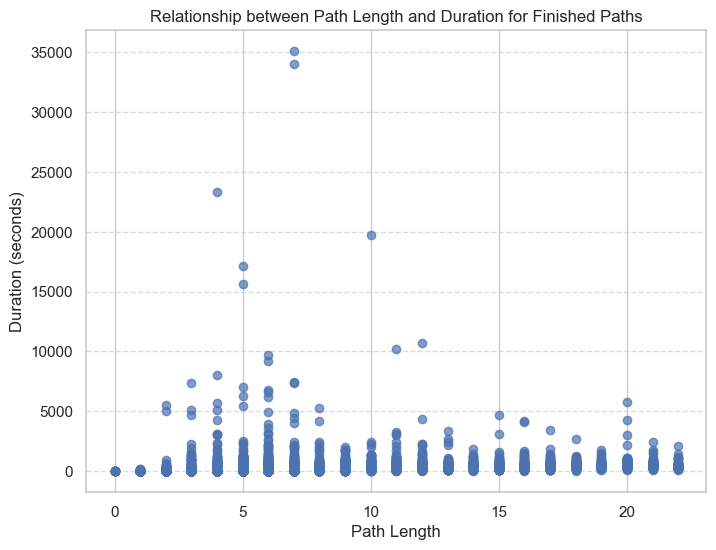

In [6]:
path_length_vs_duration(paths_finished, show=True)

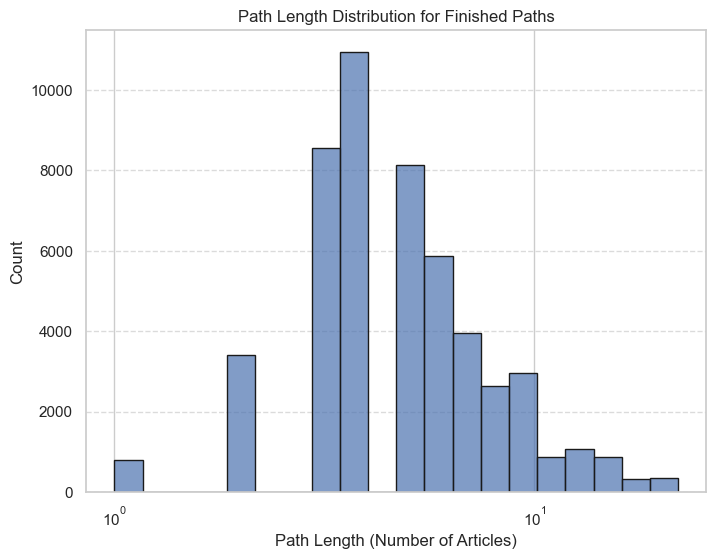

In [7]:
path_length_distribution(paths_finished, show=True)

[('<', 16009), ('United_States', 8654), ('Europe', 4270), ('United_Kingdom', 3806), ('England', 3260), ('Earth', 3152), ('Africa', 2742), ('World_War_II', 2256), ('North_America', 1829), ('Germany', 1737), ('Animal', 1642), ('France', 1570), ('Human', 1554), ('Mammal', 1548), ('Computer', 1513), ('Science', 1453), ('Periodic_table', 1396), ('English_language', 1392), ('Brain', 1301), ('Atlantic_Ocean', 1266), ('Telephone', 1239), ('India', 1210), ('Viking', 1193), ('Bird', 1183), ('Asia', 1164), ('Asteroid', 1164), ('Agriculture', 1111), ('Plant', 1105), ('China', 1104), ('Christianity', 1052), ('Japan', 1051), ('United_Nations', 1039), ('Zebra', 1029), ('Theatre', 1027), ('Internet', 1001), ('Russia', 995), ('Australia', 980), ('Chemistry', 973), ('London', 938), ('Sun', 914), ('Canada', 897), ('South_America', 891), ('European_Union', 877), ('Adolf_Hitler', 872), ('Water', 868), ('Solar_System', 857), ('President_of_the_United_States', 833), ('Italy', 832), ('Physics', 829), ('Chemic

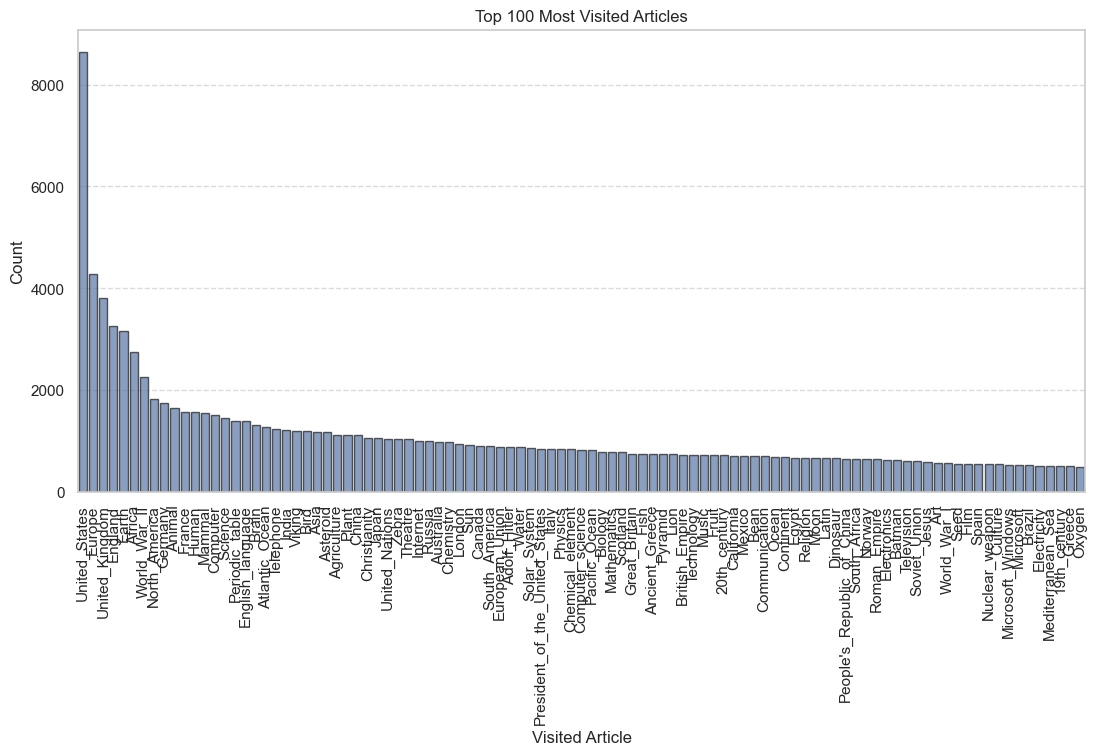

In [8]:
top_100_visited_articles(paths_finished, show=True)

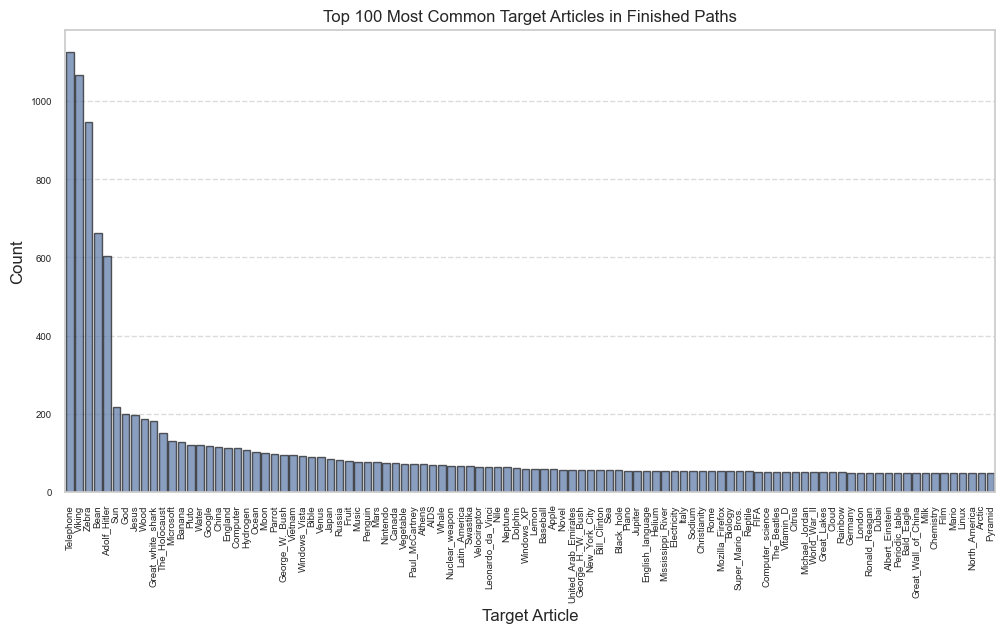

In [9]:
top_100_target_articles(paths_finished, show=True)

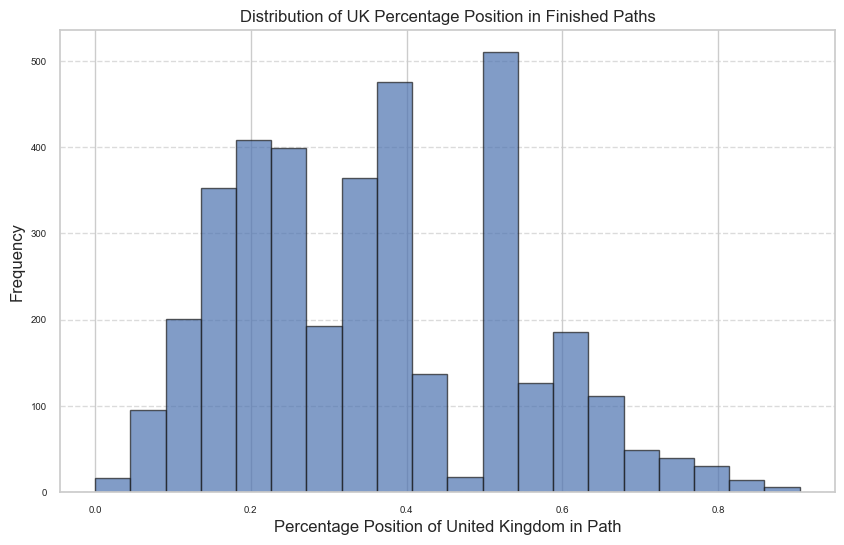

In [10]:
distribution_uk_percentage_position(paths_finished, show=True)

In [11]:
study_in_out_neighbors_uk(paths_finished, paths_unfinished, show=True)

Number of paths finished that contain United Kingdom: 3732
Number of paths unfinished that contain United Kingdom: 1354
Number of paths that finished with United Kingdom: 219


# Cliches visualization

## Cliches preprocessing

In [14]:
# define key_word for analysis: 
key_word = "United_Kingdom"

# only keep rows such that key_word in path
around_key_word = get_df_keyword(paths_finished, key_word=key_word).copy(deep=True)

# get category of the key_word
around_key_word["keyword_category"] = around_key_word["path"].apply(lambda path: get_category_keyword(key_word, path, categories))

# article juste before/just after key_word
# TODO: function to be improved/discussed. What do we want to do with "<"?
around_key_word["around_path"] = around_key_word["path"].apply(
    lambda path: get_index_keyword_in(key_word, path)
)

# update initial/target_article, initial/target_category
around_key_word["around_IA"] = around_key_word["around_path"].apply(
    lambda path: path[0]
)
around_key_word["around_TA"] = around_key_word["around_path"].apply(
    lambda path: path[-1]
)
around_key_word["around_IC"] = around_key_word["around_IA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)
around_key_word["around_TC"] = around_key_word["around_TA"].apply(
    lambda article: categories[categories["article"] == article]["category1"].values
)

around_key_word

,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,shortest_path,diff_length,target_article,uk_percentage_position,keyword_category,around_path,around_IA,around_TA,around_IC,around_TC
74,565e6dc60eeca66c,1253358736,77,"[Aberdeen, City_status_in_the_United_Kingdom, ...",0.0,5,3,2,Bread,NaN,[Geography],"[Aberdeen, City_status_in_the_United_Kingdom, ...",Aberdeen,Market,[Geography],[Business_Studies]
113,4dc8af51482ebb5a,1336876538,221,"[Achilles, Ethiopia, United_Kingdom, World_War...",3.0,4,2,2,Winston_Churchill,0.400000,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
115,0adc390d00c8c538,1344743190,63,"[Achilles, Greek_mythology, Ancient_Greece, Eu...",3.0,6,2,4,Winston_Churchill,0.571429,"[Countries, Geography, Geography]","[Europe, United_Kingdom, Prime_Minister_of_the...",Europe,Prime_Minister_of_the_United_Kingdom,[Geography],[Citizenship]
117,31980f901eee5467,1346717015,117,"[Achilles, Ethiopia, United_Kingdom, World_War...",0.0,4,2,2,Winston_Churchill,0.400000,"[Countries, Geography, Geography]","[Ethiopia, United_Kingdom, World_War_II]",Ethiopia,World_War_II,"[Geography, Countries]",[History]
121,3a11233c52f824f8,1350896212,224,"[Achilles, William_Shakespeare, England, Great...",0.0,7,2,5,Winston_Churchill,0.625000,"[Countries, Geography, Geography]","[<, United_Kingdom, World_War_II]",<,World_War_II,[],[History]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51280,6f4978c43a8faffd,1358871308,164,"[Timken_1111, Chicago, Roman_Catholic_Church, ...",0.0,5,4,1,British_monarchy,NaN,"[History, People]","[Industrial_Revolution, George_III_of_the_Unit...",Industrial_Revolution,British_monarchy,[History],[Citizenship]
51287,4e3201ac6a75f14f,1324457682,150,"[Tropical_Storm_Larry_(2003), Pacific_Ocean, U...",3.0,8,3,5,Magna_Carta,0.222222,"[Countries, Geography, Geography]","[Pacific_Ocean, United_Kingdom, England]",Pacific_Ocean,England,[Geography],[Geography]
51299,3cc4f2837bf22048,1325177555,59,"[Union_Station_(San_Diego), World_War_II, Unit...",0.0,4,2,2,Bristol,0.400000,"[Countries, Geography, Geography]","[World_War_II, United_Kingdom, England]",World_War_II,England,[History],[Geography]
51301,3278e904185ec5bc,1361584612,168,"[Valparaíso, World_Heritage_Site, Europe, <, U...",0.0,10,3,7,Hellenistic_Greece,0.363636,"[Countries, Geography, Geography]","[<, United_Kingdom, United_Nations]",<,United_Nations,[],[Citizenship]


### Visualization of cliches articles

In [15]:
from plot_helpers import *

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


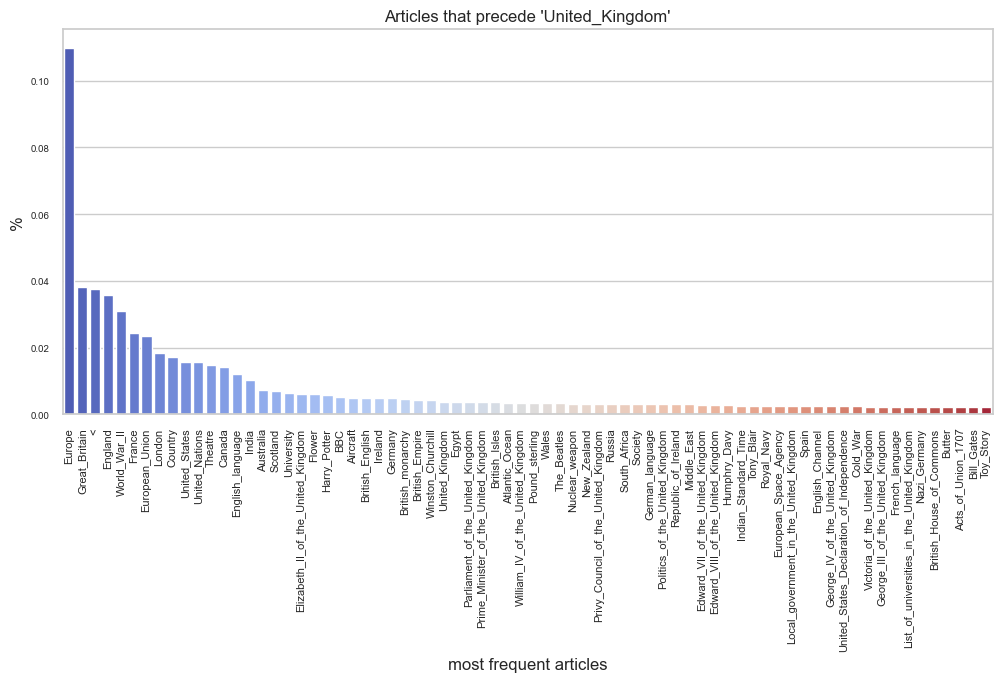

In [24]:
# keep only 10% most frequent articles just after key_word
most_frequent_before = around_key_word["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

/Users/tudoroancea/Desktop/epfl/ma3/cs-401/ada-2023-project-abracadabra2023/plot_helpers.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


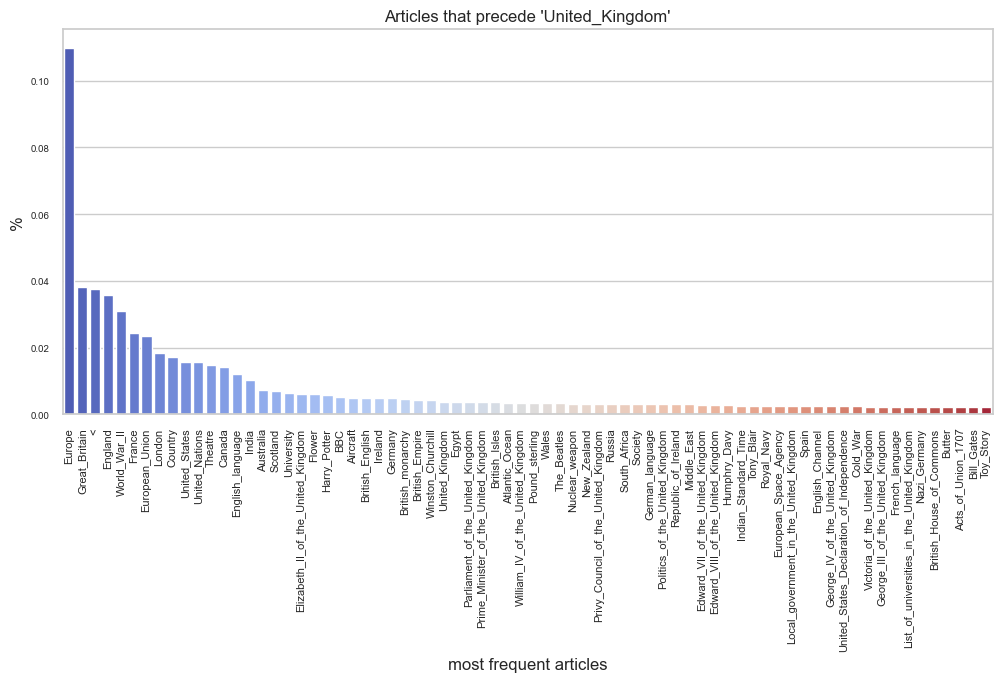

In [23]:
# keep only 10% most frequent articles just after key_word
most_frequent_before = around_key_word["around_IA"].value_counts(normalize=True)
plot_most_frequent_articles(most_frequent_before, "precede");

# Categories and cliches (working title)

In [26]:
all_categories, subcategories1, subcategories2, subcatgeories3 = separate_categories(categories)

In [28]:
results_1_step, results_2_step, results_3_step, non1, non2, non3 = analyze_nearby_articles_at_different_distances(
    paths_finished, ["category1", "category2", "category3"], categories, all_categories
)

Non-coincide Categories at 1 step away from UK: [('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'Citizenship'), ('United_Kingdom', 'Politics_and_government'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History')]
Non-coincide Categories at 2 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900')]
Non-coincide Categories at 3 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geogra

Non-coincide Categories at 1 step away from UK: [('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'Citizenship'), ('United_Kingdom', 'Politics_and_government'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History')]
Non-coincide Categories at 2 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geography'), ('United_Kingdom', 'African_Countries'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900'), ('United_Kingdom', 'History'), ('United_Kingdom', 'British_History'), ('United_Kingdom', 'British_History_Post_1900')]
Non-coincide Categories at 3 steps away from UK: [('United_Kingdom', 'Ancient_History_Classical_History_and_Mythology'), ('United_Kingdom', 'African_Geogra

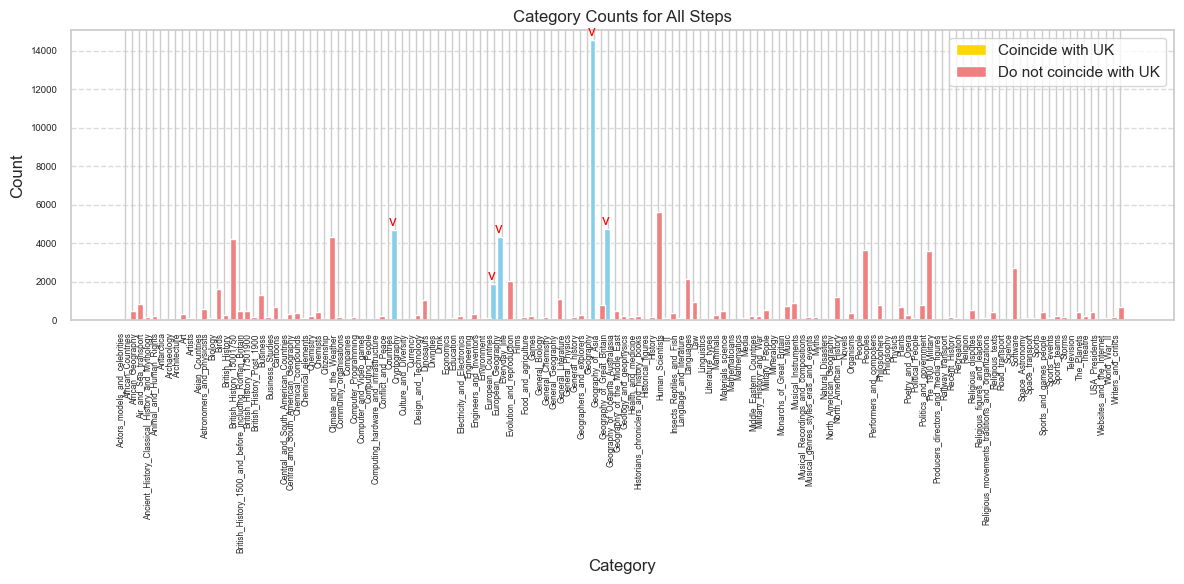

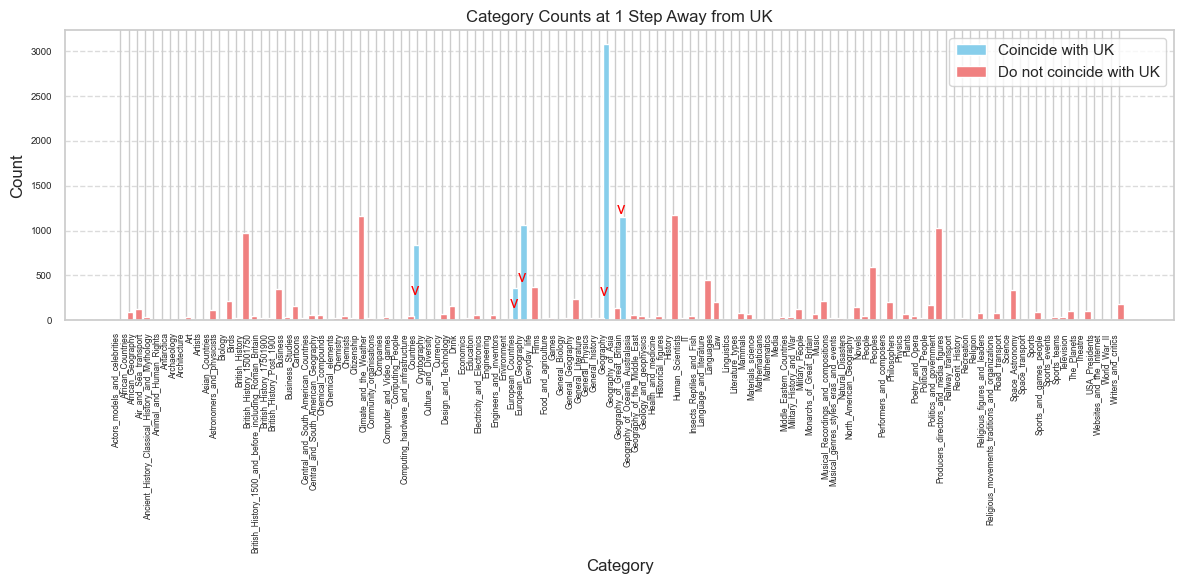

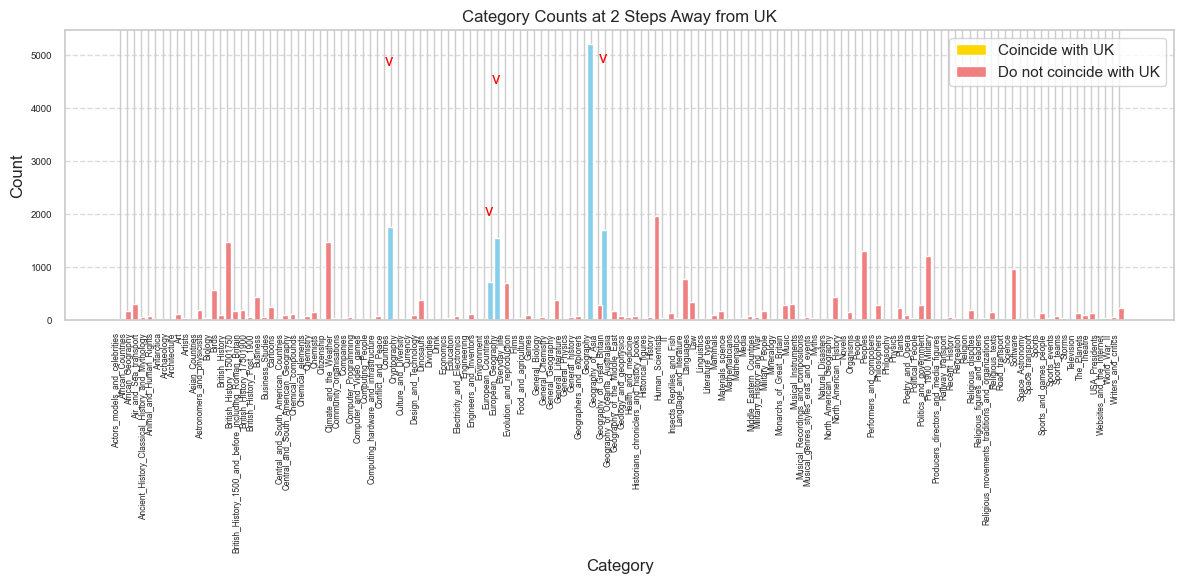

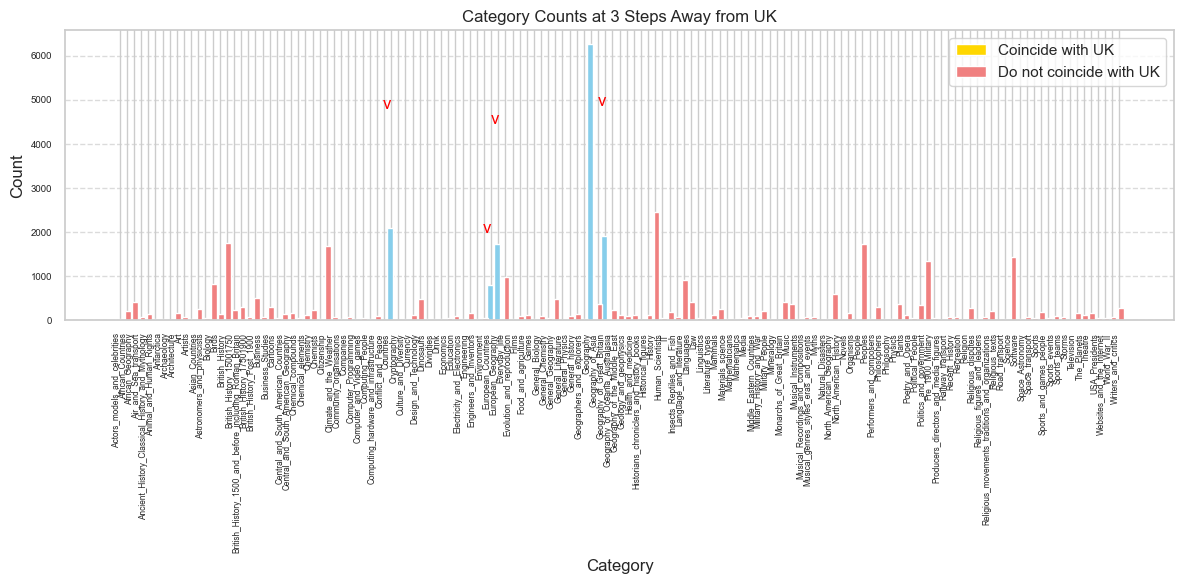

In [45]:
combine_results(paths_finished, categories, all_categories, ["category1", "category2", "category3"])